In [1]:
%matplotlib widget

#### Inflation vs. Brent
The below reproduces the behaviour of Brent and Inflation.
It also looks at the inflation vs. 5y5y expectations and how that correlates with the price of oil, like the brief research blog: https://fredblog.stlouisfed.org/2020/04/oil-prices-and-expected-inflation/

In [2]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from fredapi import Fred as FredApi

fred = FredApi(api_key='0dfcbb403eea7fee006f01e935be9216')

cpiausl = fred.get_series_latest_release('CPIAUCSL')
brent_daily = fred.get_series_latest_release('DCOILBRENTEU')
be5y5y_daily = fred.get_series_latest_release('T5YIFR')

In [3]:
# verify what the latest number available is
cpiausl.tail()

2023-07-01    304.348
2023-08-01    306.269
2023-09-01    307.481
2023-10-01    307.619
2023-11-01    307.917
dtype: float64

In [4]:
# the brent series is daily - so i resample monthly and take an average. Same for the 5y5y inflation breakeven to be used later on
brent = brent_daily.resample('M').mean()
be5y5y = be5y5y_daily.resample('M').mean()

In [5]:
# see where the Brent series stops first (only month now is relevant)
brent.tail()

2023-08-31    86.147727
2023-09-30    93.722381
2023-10-31    90.595909
2023-11-30    82.940000
2023-12-31    76.284167
Freq: M, dtype: float64

In [6]:
# it's useful to make sure that Python understands the frequency being "monthly" even though data
# don't necessarily show this. Resampling is a way around it and selecting "last" as the value of the
# resampling (there is only 1 value)
# compare the indices of the prior version of "brent" to this version of "brent" (note reassignment)
brent = brent.resample('M').last()
brent_yoy = brent.pct_change(periods=12) * 100.
brent.tail()

2023-08-31    86.147727
2023-09-30    93.722381
2023-10-31    90.595909
2023-11-30    82.940000
2023-12-31    76.284167
Freq: M, dtype: float64

In [7]:
# now extend the brent timeseries with a constant one
new_index = pd.date_range(start=brent.index[-1], freq='M', periods=12)
brent_projection = pd.Series(data=brent.iloc[-1], index=new_index)
# concatenate the two brent timeseries one to the other
brent_extended = pd.concat([brent, brent_projection.iloc[1:]])
brent_extended.tail(24)

2022-12-31    80.924000
2023-01-31    82.501429
2023-02-28    82.585000
2023-03-31    78.434348
2023-04-30    84.638333
2023-05-31    75.466000
2023-06-30    74.839091
2023-07-31    80.108095
2023-08-31    86.147727
2023-09-30    93.722381
2023-10-31    90.595909
2023-11-30    82.940000
2023-12-31    76.284167
2024-01-31    76.284167
2024-02-29    76.284167
2024-03-31    76.284167
2024-04-30    76.284167
2024-05-31    76.284167
2024-06-30    76.284167
2024-07-31    76.284167
2024-08-31    76.284167
2024-09-30    76.284167
2024-10-31    76.284167
2024-11-30    76.284167
Freq: M, dtype: float64

In [8]:
# make a yoy variation as a % change for the CPI
# note the change in index as well here... same as above
cpiausl = cpiausl.resample('M').last()
cpiausl_yoy = cpiausl.pct_change(periods=12) * 100.
cpiausl_yoy.tail()

2023-07-31    3.299075
2023-08-31    3.707504
2023-09-30    3.689903
2023-10-31    3.232356
2023-11-30    3.120918
Freq: M, dtype: float64

In [9]:
# make a yoy variation as a % change for the extended brent projection
# and then check the numbers vs. what you have above to see if it makes
# sense (good practice!)
brent_extended_yoy = brent_extended.pct_change(periods=12) * 100.
brent_extended_yoy.tail(12)

2023-12-31    -5.733569
2024-01-31    -7.535945
2024-02-29    -7.629513
2024-03-31    -2.741377
2024-04-30    -9.870429
2024-05-31     1.084153
2024-06-30     1.930910
2024-07-31    -4.773461
2024-08-31   -11.449589
2024-09-30   -18.606243
2024-10-31   -15.797338
2024-11-30    -8.024877
Freq: M, dtype: float64

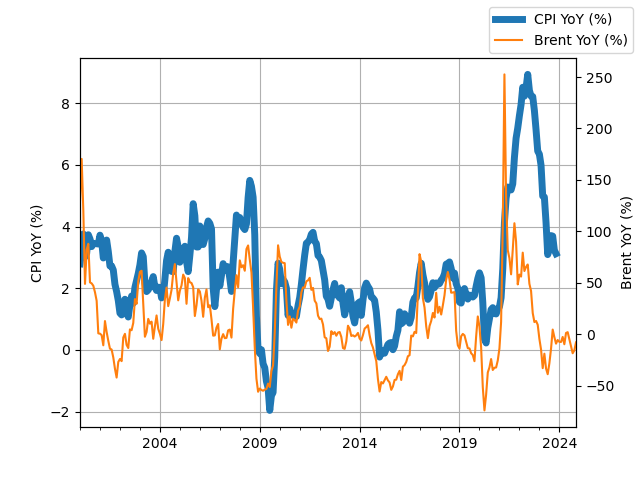

In [10]:
# plot and set labels of the figure
START_YEAR = '2000'
fig, ax = plt.subplots()
cpiausl_yoy.loc[START_YEAR:].plot(ax=ax, linewidth=5);
ax2 = brent_extended_yoy.loc[START_YEAR:].plot(secondary_y=True, ax=ax);
ax.grid(True);
ax.set_ylabel('CPI YoY (%)');
ax2.set_ylabel('Brent YoY (%)');
ax.figure.legend(['CPI YoY (%)','Brent YoY (%)']);

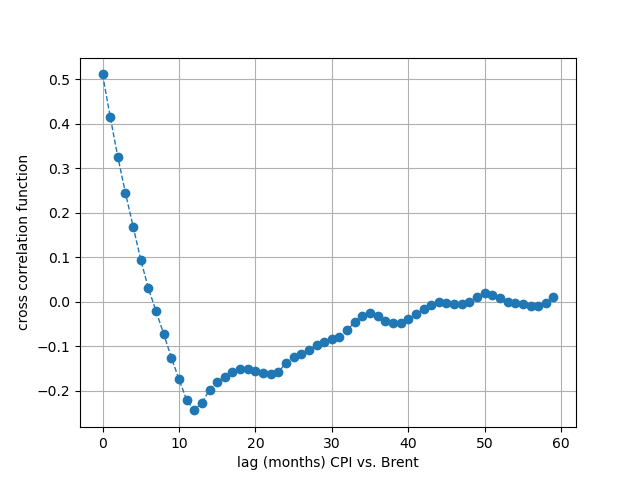

In [11]:
# now let's try to cross-correlate these 2 indicators to see the lags at which there is some correlation 
# and how big that is. To do so, we only look at the real data available, not the extended brent series.
import statsmodels.tsa.stattools as smtsast
common_dates = brent_yoy.loc[~brent_yoy.isna()].index.intersection(cpiausl_yoy.index)
cc = smtsast.ccf(brent_yoy.loc[common_dates], cpiausl_yoy.loc[common_dates])
cross_correl_function = pd.Series(cc[:60])
fig, ax = plt.subplots()
cross_correl_function.plot(ax=ax, linewidth=1, style='o--');
ax.grid(True);
ax.set_xlabel('lag (months) CPI vs. Brent');
ax.set_ylabel('cross correlation function');

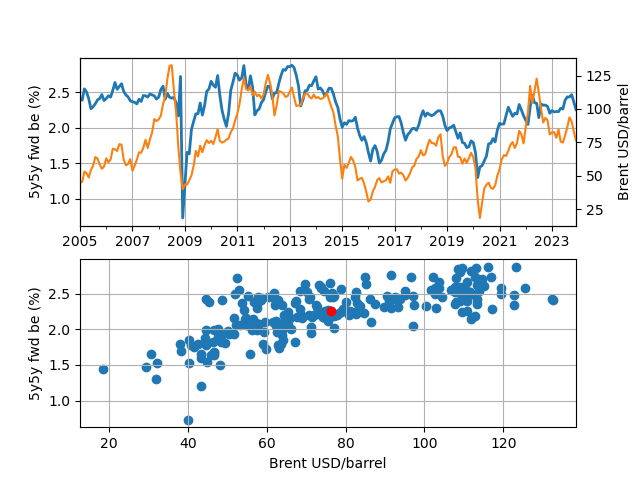

In [13]:
# let's also plot the history of the brent vs. the inflation rate and create a regression analysis with the latest value highlighted in a different colour
# the paper suggests to do this from 2005 (or after the great recession) onwards
START_YEAR = '2005'
fig, ax = plt.subplots(2,1)
ax1 = be5y5y.loc[START_YEAR:].plot(ax=ax[0], linewidth=2);
ax2 = brent.loc[START_YEAR:].plot(secondary_y=True, ax=ax[0]);
ax[0].grid(True);
ax1.set_ylabel('5y5y fwd be (%)');
ax2.set_ylabel('Brent USD/barrel');
plt.sca(ax[1])
tmp = brent.loc[START_YEAR:]
plt.scatter(tmp, be5y5y.loc[tmp.index]);
plt.scatter(tmp.iloc[-1], be5y5y.iloc[-1], color='r')
ax[1].grid(True);
ax[1].set_ylabel('5y5y fwd be (%)');
ax[1].set_xlabel('Brent USD/barrel');